# **Question 5**
RBF

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1GhboU0WbIo5tYZu8GNB7hFJa-fx04mcr


Downloading...
From: https://drive.google.com/uc?id=1GhboU0WbIo5tYZu8GNB7hFJa-fx04mcr
To: /content/AirQualityUCI.csv
100% 793k/793k [00:00<00:00, 32.5MB/s]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rbf_kernel_layer_3 (RBFKernelLayer)  │ (None, 10)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2991 - mae: 1.1315 - val_loss: 1.1130 - val_mae: 1.0471
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0620 - mae: 1.0233 - val_loss: 0.8942 - val_mae: 0.9378
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8433 - mae: 0.9103 - val_loss: 0.7083 - val_mae: 0.8336
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6597 - mae: 0.8048 - val_loss: 0.5534 - val_mae: 0.7351
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5142 - mae: 0.7083 - val_loss: 0.4273 - val_mae: 0.6435
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3950 - mae: 0.6185 - val_loss: 0.3267 - val_mae: 0.5595
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2972 - mae: 0.5335 - val_loss: 0.2477 - val_mae: 0.4829
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2279 - mae: 0.4615 - val_loss: 0.1869 - val_mae: 0.4140
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.16

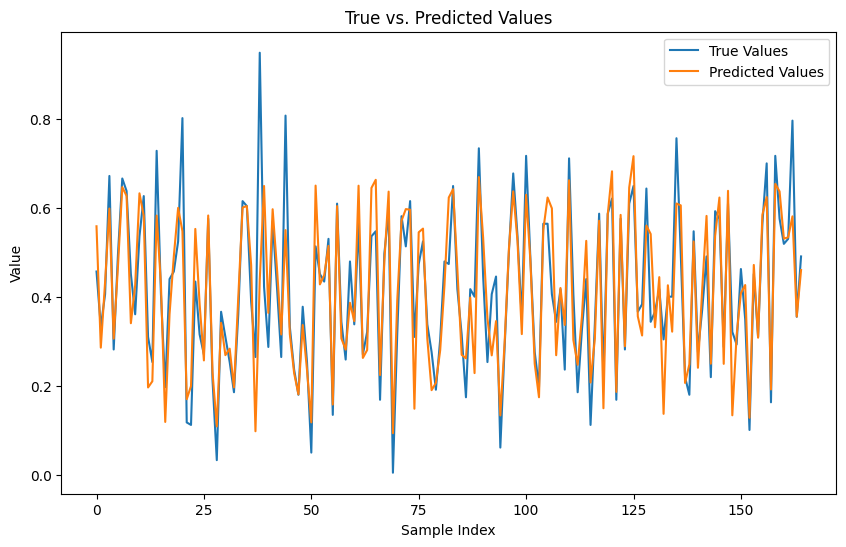

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model

# Load and preprocess dataset
dataset = pd.read_csv('AirQualityUCI.csv')
dataset = dataset.iloc[:, 2:]

# Remove empty columns and rows
dataset.dropna(axis=0, how='all', inplace=True)
dataset.dropna(axis=1, how='all', inplace=True)

# Filter out invalid data entries
dataset = dataset[~(dataset == -200).any(axis=1)]

dataset.to_csv('processed_output.csv', index=False)

features = dataset.drop(columns=['NO2(GT)']).values
target = dataset['NO2(GT)'].values.reshape(-1, 1)

scaler = MinMaxScaler()
target = scaler.fit_transform(target)
features = scaler.fit_transform(features)

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class RBFKernelLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFKernelLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = tf.constant(gamma, dtype=tf.float32)

    def build(self, input_shape):
        self.centroids = self.add_weight(
            name='centroids',
            shape=(self.units, input_shape[-1]),
            initializer='random_uniform',
            trainable=True
        )
        super(RBFKernelLayer, self).build(input_shape)

    def call(self, inputs):
        squared_diff = tf.expand_dims(inputs, axis=1) - self.centroids
        l2_norm = tf.reduce_sum(tf.square(squared_diff), axis=-1)
        return tf.exp(-self.gamma * l2_norm)

num_features = X_train.shape[1]
num_rbf_units = 10
gamma_value = 0.3

input_layer = Input(shape=(num_features,))
rbf_layer = RBFKernelLayer(units=num_rbf_units, gamma=gamma_value)(input_layer)
output_layer = Dense(1, activation='linear')(rbf_layer)
rbf_network = Model(inputs=input_layer, outputs=output_layer)

rbf_network.compile(optimizer='adam', loss='mse', metrics=['mae'])

rbf_network.summary()

training_history = rbf_network.fit(X_train, y_train, validation_data=(X_val, y_val),
                                   epochs=150, batch_size=50, verbose=1)

# Evaluate performance
test_loss, test_mae = rbf_network.evaluate(X_test, y_test)
print(f"RBF Network - Loss: {test_loss}, MAE: {test_mae}")

# Predict on the test set
y_pred = rbf_network.predict(X_test)

# Plot the first 100 samples
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()
